In [8]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
import scienceplots             # needed for 'science' style

# ensure inline rendering matches saved figure / uncomment for larger inline figures
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

DATA_DIR = Path("results")
FIG_DIR  = Path("figures")

# layout defaults and common labels
SINGLE_COL_WIDTH = 3.5
DOUBLE_COL_WIDTH = 7.16
DPI = 150
FIELD_SYMBOL = "g"
SUPPORT_LABEL_T = r"Support $g$"

# z-ordering
Z_BG   = 0
Z_REF  = 2
Z_DATA = 3

# global plot styling using scienceplots
plt.style.use(["science", "ieee"])
plt.rcParams.update({"mathtext.fontset": "cm", "text.usetex": False})

# hardcoded seaborn-colorblind palette
SB_COLORBLIND = [
    "#0173b2", "#de8f05", "#029e73", "#d55e00", "#cc78bc",
    "#ca9161", "#fbafe4", "#949494", "#ece133", "#56b4e9",
]

STYLE_REF = {
    "linestyle": "--", "color": "black", "alpha": 0.7,
    "linewidth": 1.0, "label": "ED Reference",
}

STYLE_MAIN = {
    "linestyle": "-", "linewidth": 1.0, "alpha": 0.9, "marker": "o",
    "markeredgewidth": 0.0, "color": SB_COLORBLIND[0],
}

print("Global styles defined.")

Global styles defined.


In [4]:
DATA_FILENAME = "tfim_16_entangle_rbm_err_20260123_015209.csv"
REF_FILENAME  = "tfim_16_entropy_ref.csv"

df_res = pd.read_csv(DATA_DIR / DATA_FILENAME)

ref_path = DATA_DIR / REF_FILENAME
ref_df = pd.read_csv(ref_path) if ref_path.exists() else pd.DataFrame()

# ensure numeric types for magnetic field
df_res["h"] = df_res["h"].astype(float)
if not ref_df.empty:
    ref_df["h"] = ref_df["h"].astype(float)

# preprocess for 3d surface by pivoting (rows: l, cols: h, values: s2)
pivot_df = df_res.pivot(index="l", columns="h", values="s2")
pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1)  # monotonic mesh

h_dense  = pivot_df.columns.values.astype(float)
l_values = pivot_df.index.values.astype(int)
Z_s2     = pivot_df.values

# also extract error surface (same mesh as Z_s2)
if "s2_err" in df_res.columns:
    pivot_err_df = df_res.pivot(index="l", columns="h", values="s2_err")
    pivot_err_df = pivot_err_df.sort_index(axis=0).sort_index(axis=1)
    Z_s2_err     = pivot_err_df.values
else:
    Z_s2_err = None
    print("Warning: column 's2_err' not found in df_res.")

# identify support cuts from data
support_h_keys = np.sort(df_res[df_res["type"] == "support"]["h"].unique())

# precompute color map nd cut data (used by multiple figures)
h_sorted = sorted([float(h) for h in support_h_keys])
h_to_color = {h0: SB_COLORBLIND[i % len(SB_COLORBLIND)] for i, h0 in enumerate(h_sorted)}

cut_data = {}
for h0 in h_sorted:
    subset = df_res[df_res["h"] == h0].sort_values("l")
    cut_data[h0] = {
        "ell": subset["l"].values,
        "s2":  subset["s2"].values,
        "s2_err": subset["s2_err"].values if "s2_err" in subset.columns else None,
    }

# precompute ED reference curves
def _extract_ref_curve(ref_df_local: pd.DataFrame, h0: float):
    if ref_df_local.empty:
        return None

    mask = np.isclose(ref_df_local["h"].values, h0, atol=1e-6)
    if not mask.any():
        return None

    row = ref_df_local.loc[mask].iloc[0]

    x_ref, y_ref = [], []
    for c in ref_df_local.columns:
        if c.startswith("l"):
            x_ref.append(int(c[1:]))
            y_ref.append(float(row[c]))

    if not x_ref:
        return None

    x_ref = np.asarray(x_ref)
    y_ref = np.asarray(y_ref)
    order = np.argsort(x_ref)
    return x_ref[order], y_ref[order]

ref_curves = {h0: _extract_ref_curve(ref_df, h0) for h0 in h_sorted} if not ref_df.empty else {}

print(f"Data Loaded.")
print(f"Dimensions: h={len(h_dense)}, l={len(l_values)}")
print(f"Support cuts found at {FIELD_SYMBOL}={support_h_keys}")

Data Loaded.
Dimensions: h=7, l=8
Support cuts found at g=[0.5  0.8  0.95 1.   1.05 1.2  1.5 ]


Saved: tfim_4x4_entropy_2d.pdf


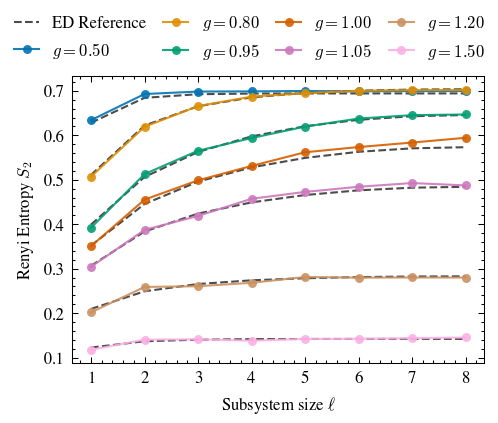

In [5]:
FIG_NAME = "tfim_4x4_entropy_2d.pdf"

# local styling
FIG_HEIGHT_RATIO = 0.85
width  = SINGLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO
MARKER_SIZE  = 4.3
MARKER_EDGEW = 0.0

# legend config
LEGEND_ANCHOR = (0.43, 1.03)
LEGEND_LOC    = "lower center"
LEGEND_NCOL   = 4

fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

ref_label_added = False

for h0 in h_sorted:
    ell = cut_data[h0]["ell"]
    s2  = cut_data[h0]["s2"]
    color = h_to_color[h0]

    # reference curve
    curve = ref_curves.get(h0)
    if curve is not None:
        x_ref, y_ref = curve

        style_local = STYLE_REF.copy()
        style_local["label"] = style_local["label"] if not ref_label_added else "_nolegend_"

        ax.plot(x_ref, y_ref, **style_local, zorder=Z_REF)
        ref_label_added = True

    # model curve
    ax.plot(
        ell, s2,
        label=rf"${FIELD_SYMBOL}={h0:.2f}$",
        color=color,
        linestyle=STYLE_MAIN["linestyle"],
        linewidth=STYLE_MAIN["linewidth"],
        alpha=STYLE_MAIN["alpha"],
        marker=STYLE_MAIN["marker"],
        markersize=MARKER_SIZE,
        fillstyle="full",
        markerfacecolor=color,
        markeredgecolor=color,
        markeredgewidth=MARKER_EDGEW,
        zorder=Z_DATA,
    )

ax.set_xlabel(r"Subsystem size $\ell$")
ax.set_ylabel(r"Renyi Entropy $S_2$")
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
ax.grid(False)

leg = ax.legend(
    frameon=False, ncol=LEGEND_NCOL, loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_ANCHOR, columnspacing=1.0,
    handlelength=1.5, borderaxespad=0.0,
)

fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight", bbox_extra_artists=[leg])
    print(f"Saved: {FIG_NAME}")

plt.show()

Saved: tfim_4x4_entropy_2d.pdf


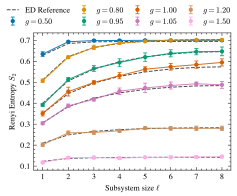

In [12]:
FIG_NAME = "tfim_4x4_entropy_2d.pdf"

# local styling
FIG_HEIGHT_RATIO = 0.85
width  = SINGLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO
MARKER_SIZE  = 4.3

# vanilla errorbar styling
ERR_CAPSIZE   = 2
ERR_LINEWIDTH = 0.8

# legend config
LEGEND_ANCHOR = (0.43, 1.03)
LEGEND_LOC    = "lower center"
LEGEND_NCOL   = 4

fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

ref_label_added = False

for h0 in h_sorted:
    ell = cut_data[h0]["ell"]
    s2  = cut_data[h0]["s2"]
    s2_err = cut_data[h0].get("s2_err", None)
    color = h_to_color[h0]

    # reference curve
    curve = ref_curves.get(h0)
    if curve is not None:
        x_ref, y_ref = curve
        style_local = STYLE_REF.copy()
        style_local["label"] = style_local["label"] if not ref_label_added else "_nolegend_"
        ax.plot(x_ref, y_ref, **style_local, zorder=Z_REF)
        ref_label_added = True

    if s2_err is not None:
        # 1) main line (no markers, no legend)
        ax.plot(
            ell, s2,
            color=color,
            linestyle=STYLE_MAIN["linestyle"],
            linewidth=STYLE_MAIN["linewidth"],
            alpha=STYLE_MAIN["alpha"],
            label="_nolegend_",
            zorder=Z_DATA,
        )

        # 2) markers + error bars (THIS gets the legend label)
        ax.errorbar(
            ell, s2, yerr=s2_err,
            fmt=STYLE_MAIN["marker"],
            linestyle="None",
            markersize=MARKER_SIZE,
            color=color,
            markerfacecolor=color,
            markeredgecolor="none",   # keep “no outline” without nuking caps
            ecolor=color,
            elinewidth=ERR_LINEWIDTH,
            capsize=ERR_CAPSIZE,
            capthick=ERR_LINEWIDTH,
            label=rf"${FIELD_SYMBOL}={h0:.2f}$",
            zorder=Z_DATA + 1,
        )
    else:
        # fallback: no errors -> normal line+markers (and legend)
        ax.plot(
            ell, s2,
            label=rf"${FIELD_SYMBOL}={h0:.2f}$",
            color=color,
            linestyle=STYLE_MAIN["linestyle"],
            linewidth=STYLE_MAIN["linewidth"],
            alpha=STYLE_MAIN["alpha"],
            marker=STYLE_MAIN["marker"],
            markersize=MARKER_SIZE,
            fillstyle="full",
            markerfacecolor=color,
            markeredgecolor="none",
            zorder=Z_DATA,
        )

ax.set_xlabel(r"Subsystem size $\ell$")
ax.set_ylabel(r"Renyi Entropy $S_2$")
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
ax.grid(False)

leg = ax.legend(
    frameon=False, ncol=LEGEND_NCOL, loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_ANCHOR, columnspacing=1.0,
    handlelength=1.5, borderaxespad=0.0,
)

fig.tight_layout()

if FIG_NAME:
    fig.savefig(FIG_DIR / FIG_NAME, bbox_inches="tight", bbox_extra_artists=[leg])
    print(f"Saved: {FIG_NAME}")

plt.show()
